BANN project: Experiment to show benfits of using BANN

So far, 

In [1]:
import numpy as np
import os
import tensorflow as tf
import import_ipynb

from basicCNN_Alex import ConvNet
from SDT_models_Alex import SoftBinaryDecisionTree
from SDT_Utils_Alex import brand_new_tfsession, draw_tree
from tensorflow.keras.callbacks import EarlyStopping, Callback

sess = brand_new_tfsession()

C:\Users\LG\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


importing Jupyter notebook from basicCNN_Alex.ipynb
importing Jupyter notebook from SDT_models_Alex.ipynb
importing Jupyter notebook from SDT_Utils_Alex.ipynb


MNIST Dataset will be used to test SDT

In [2]:
#load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# add channel dim
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

# hold out last 10000 training samples for validation
x_valid, y_valid = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(50000, 28, 28, 1) (50000,) (10000, 28, 28, 1) (10000,) (10000, 28, 28, 1) (10000,)


In [3]:
# retrieve image and label shapes from training data
img_rows, img_cols, img_chans = x_train.shape[1:]
n_classes = np.unique(y_train).shape[0]

print(img_rows, img_cols, img_chans, n_classes)

28 28 1 10


In [4]:
# convert labels to 1-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

print(y_train.shape, y_valid.shape, y_test.shape)

(50000, 10) (10000, 10) (10000, 10)


In [5]:
# normalize inputs and cast to float
x_train = (x_train / np.max(x_train)).astype(np.float32)
x_valid = (x_valid / np.max(x_valid)).astype(np.float32)
x_test = (x_test / np.max(x_test)).astype(np.float32)

**Neural Network**
Convolutional neural network is used that is given by keras MNIST-CNN example.
For details about model architecture check 'basicCNN_Alex.ipynb'

In [6]:
nn = ConvNet(img_rows, img_cols, img_chans, n_classes)
nn.maybe_train(data_train=(x_train, y_train),
               data_valid=(x_valid, y_valid),
               batch_size=16, epochs=12)
nn.evaluate(x_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Loading trained model from assets/nn-model.hdf5.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.0035 - acc: 0.9989
accuracy: 99.89% | loss: 0.003480323760046376


In [7]:
nn.evaluate(x_valid, y_valid)
nn.evaluate(x_test, y_test)

10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0349 - acc: 0.9901
accuracy: 99.01% | loss: 0.03487693210659445
10000/10000 [==============================] - 15s 1ms/sample - loss: 0.0285 - acc: 0.9915
accuracy: 99.15% | loss: 0.02848046284560578


Soft lable extraction for distillation

In [8]:
y_train_soft = nn.predict(x_train)
y_train_soft.shape

50000/50000 [==============================] - 72s 1ms/sample


(50000, 10)

**Binary Soft Decision Tree**

In [9]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_valid_flat = x_valid.reshape((x_valid.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

#import matplotlib.pyplot as plt
#%matplotlib inline
#plt.imshow(x_test_flat.reshape((x_test_flat.shape[0], img_rows, img_cols))[1])

x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape

((50000, 784), (10000, 784), (10000, 784))

Hyperparameters

- tree_depth: as denoted in the [paper], depth is in terms of inner nodes (excluding leaves / indexing depth from 0)
- penalty_strength: regularization penalty strength
- penalty_decay: regularization penalty decay: paper authors found 0.5 optimal (note that $2^{-d} = 0.5^d$ as we use it)
- ema_win_size: scaling factor to the "default size of the window" used to calculate moving averages (growing exponentially with depth) of node and path probabilities
- inv_temp: scale logits of inner nodes to "avoid very soft decisions" [paper] pass 0 to indicate that this should be a learned parameter (single scalar learned to apply to all nodes in the tree)
- learning_rate: hopefully no need to explain, but let's be cool and use Karpathy constant (source) :D as default in tree.__init__()
- batch_size: we use a small one, because with increasing depth and thus amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimization properties

In [10]:
n_features = img_rows * img_cols * img_chans
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-03
batch_size = 4

**Regular training with hard labels : SDT**

In [11]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


In [12]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/non-distilled/checkpoint')
# for f in glob.glob('assets/non-distilled/tree-model*'):
#     os.remove(f)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es])

Loading trained model from assets/non-distilled/tree-model.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from assets/non-distilled/tree-model


In [13]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

10000/10000 [==============================] - 12s 1ms/sample - loss: 16.1456 - acc: 0.8164
accuracy: 81.64% | loss: 16.14563472480774
10000/10000 [==============================] - 12s 1ms/sample - loss: 16.1143 - acc: 0.8088
accuracy: 80.88% | loss: 16.114324585342406


**Distillation: Training with soft labels: SDT**

In [14]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


In [15]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

#'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/distilled/checkpoint')
# for f in glob.glob('assets/distilled/tree-model*'):
#     os.remove(f)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train_soft), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=True)

Loading trained model from assets/distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/distilled/tree-model


In [16]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

10000/10000 [==============================] - 11s 1ms/sample - loss: 8.6628 - acc: 0.9165
accuracy: 91.65% | loss: 8.662780070304871
10000/10000 [==============================] - 12s 1ms/sample - loss: 8.6430 - acc: 0.9071
accuracy: 90.71% | loss: 8.642953238296508


**Distillation: Training with soft labels(CNN as teacher): BANN**

In [17]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
from functools import partial
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm

In [18]:
def l21_norm(W):
    # Computes the L21 norm of a symbolic matrix W
    return tf.reduce_sum(tf.norm(W, axis=1))

def group_regularization(v):
    # Computes a group regularization loss from a list of weight matrices corresponding
    # to the different layers
    const_coeff = lambda W: tf.sqrt(tf.cast(W.get_shape().as_list()[1], tf.float32))
    return tf.reduce_sum([tf.multiply(const_coeff(W), l21_norm(W)) for W in v if 'bias' not in W.name])

def group_regularization_player(v):
	const_coeff = lambda W: tf.sqrt(tf.cast(W.get_shape().as_list()[1], tf.float32))
	return tf.reduce_sum(tf.multiply(const_coeff(v), l21_norm(v)))

def custom_group_regularization_player(v, g_scalevec):
	#const_coeff = lambda W: tf.sqrt(tf.cast(W.get_shape().as_list()[1], tf.float32))
	return tf.reduce_sum(tf.multiply(tf.norm(v, axis=1), g_scalevec))

def friedman_suite(x):
	return 10 * np.sin(np.pi * x[0] * x[1]) + 20 * (x[2] - 0.5)**2 + 10 * x[3] + 5 * x[4]

def get_grd_importance(iXtest):
	nsamples = iXtest.shape[0]
	isum = 0.0
	for i in range(nsamples):
		isum = isum + friedman_suite(iXtest[i, :])
	isum = isum * 1.0 / nsamples
	return isum

def f11_suite(x):
    interaction1 = 10 * np.exp(x[:, 0]*x[:, 1])
    interaction4 = 2 * np.arcsin(x[:, 8] * x[:, 9])
    y=interaction1 + interaction4
    return y

def get_grd_importance_f(iXtest):
	isum = f11_suite(iXtest)
	return np.mean(isum)

def get_grd_importance_f4(iXtest):
	isum = f4_suite(iXtest)
	return np.mean(isum)

In [19]:
x_train_flat.shape
y_train_soft.shape

(50000, 10)

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
n_inputs =784
n_hidden1 = 4
n_hidden2 = 3
n_hidden3 = 2
n_hidden4 = 5
n_hidden5 = 2
n_hidden6 = 5
n_hidden7 = 3
n_hidden8 = 5
n_hidden9 = 7
n_hidden10 = 5
n_hidden11 = 7
n_hidden22 = 8
n_hidden33 = 8
n_hidden44 = 6
n_hidden55 = 9
n_hidden66 = 7
n_hidden77 = 5
n_hidden88 = 10
n_hidden99 = 12
n_hidden1010 = 13
n_outputs = 10
g_scale = 1
thresh = 0.5
dropout_rate = 0.2
n_hiddens = n_hidden1 + n_hidden2 + n_hidden3 + n_hidden4 + n_hidden5 + n_hidden6 + n_hidden7 + n_hidden8 + n_hidden9 + n_hidden10
elems_scale = [0.1] * n_hiddens
#elems_scale[0] = 0.0001, not very useful
#elems_scale[1] = 0.0001, not very useful
#g_scalevec = tf.constant([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
g_scalevec = tf.constant(elems_scale)
training = tf.placeholder_with_default(False, shape=(), name='training')
X = tf.placeholder(tf.float32, (None, n_inputs), name='X')
y = tf.placeholder(tf.float32, (None, n_outputs), name = 'y')

In [21]:
with tf.name_scope('dnn'):
	hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
	hidden2 = tf.layers.dense(X, n_hidden2, activation=tf.nn.relu, name='hidden2')
	hidden3 = tf.layers.dense(X, n_hidden3, activation=tf.nn.relu, name='hidden3')
	hidden4 = tf.layers.dense(X, n_hidden4, activation=tf.nn.relu, name='hidden4')
	hidden5 = tf.layers.dense(X, n_hidden5, activation=tf.nn.relu, name='hidden5')
	hidden6 = tf.layers.dense(X, n_hidden6, activation=tf.nn.relu, name='hidden6')
	hidden7 = tf.layers.dense(X, n_hidden7, activation=tf.nn.relu, name='hidden7')
	hidden8 = tf.layers.dense(X, n_hidden8, activation=tf.nn.relu, name='hidden8')
	hidden9 = tf.layers.dense(X, n_hidden9, activation=tf.nn.relu, name='hidden9')
	hidden10 = tf.layers.dense(X, n_hidden10, activation=tf.nn.relu, name='hidden10')
	hidden1_1 = tf.layers.dense(hidden1, n_hidden11, activation=tf.nn.relu, name='hidden1_1')
	hidden1_1drop = tf.layers.dropout(hidden1_1, dropout_rate, training=training)
	hidden1_2 = tf.layers.dense(hidden2, n_hidden22, activation=tf.nn.relu, name='hidden1_2')
	hidden1_2drop = tf.layers.dropout(hidden1_2, dropout_rate, training=training)
	hidden1_3 = tf.layers.dense(hidden3, n_hidden33, activation=tf.nn.relu, name='hidden1_3')
	hidden1_3drop = tf.layers.dropout(hidden1_3, dropout_rate, training=training)
	hidden1_4 = tf.layers.dense(hidden4, n_hidden44, activation=tf.nn.relu, name='hidden1_4')
	hidden1_4drop = tf.layers.dropout(hidden1_4, dropout_rate, training=training)
	hidden1_5 = tf.layers.dense(hidden5, n_hidden55, activation=tf.nn.relu, name='hidden1_5')
	hidden1_5drop = tf.layers.dropout(hidden1_5, dropout_rate, training=training)
	hidden1_6 = tf.layers.dense(hidden6, n_hidden66, activation=tf.nn.relu, name='hidden1_6')
	hidden1_6drop = tf.layers.dropout(hidden1_6, dropout_rate, training=training)
	hidden1_7 = tf.layers.dense(hidden7, n_hidden77, activation=tf.nn.relu, name='hidden1_7')
	hidden1_7drop = tf.layers.dropout(hidden1_7, dropout_rate, training=training)
	hidden1_8 = tf.layers.dense(hidden8, n_hidden88, activation=tf.nn.relu, name='hidden1_8')
	hidden1_8drop = tf.layers.dropout(hidden1_8, dropout_rate, training=training)
	hidden1_9 = tf.layers.dense(hidden9, n_hidden99, activation=tf.nn.relu, name='hidden1_9')
	hidden1_9drop = tf.layers.dropout(hidden1_9, dropout_rate, training=training)
	hidden1_10 = tf.layers.dense(hidden10, n_hidden1010, activation=tf.nn.relu, name='hidden1_10')
	hidden1_10drop = tf.layers.dropout(hidden1_10, dropout_rate, training=training)
	hidden_cat = tf.concat([hidden1_1drop, hidden1_2drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_3drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_4drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_5drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_6drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_7drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_8drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_9drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_10drop], 1)
	hidden_cat_drop = tf.layers.dropout(hidden_cat, dropout_rate, training=training)
	logits = tf.layers.dense(hidden_cat_drop, n_outputs, name='outputs')
	simu = tf.reduce_mean(logits)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [74]:
#tf.reset_default_graph()

In [22]:
W_h1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W_h2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
W_h3 = tf.get_default_graph().get_tensor_by_name("hidden3/kernel:0")
W_h4 = tf.get_default_graph().get_tensor_by_name("hidden4/kernel:0")
W_h5 = tf.get_default_graph().get_tensor_by_name("hidden5/kernel:0")
W_h6 = tf.get_default_graph().get_tensor_by_name("hidden6/kernel:0")
W_h7 = tf.get_default_graph().get_tensor_by_name("hidden7/kernel:0")
W_h8 = tf.get_default_graph().get_tensor_by_name("hidden8/kernel:0")
W_h9 = tf.get_default_graph().get_tensor_by_name("hidden9/kernel:0")
W_h10 = tf.get_default_graph().get_tensor_by_name("hidden10/kernel:0")
W_cat = tf.concat([W_h1, W_h2], 1)
W_cat = tf.concat([W_cat, W_h3], 1)
W_cat = tf.concat([W_cat, W_h4], 1)
W_cat = tf.concat([W_cat, W_h5], 1)
W_cat = tf.concat([W_cat, W_h6], 1)
W_cat = tf.concat([W_cat, W_h7], 1)
W_cat = tf.concat([W_cat, W_h8], 1)
W_cat = tf.concat([W_cat, W_h9], 1)
W_cat = tf.concat([W_cat, W_h10], 1)
W_rcat = tf.transpose(W_cat)

In [23]:
with tf.name_scope('loss'):
	base_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
	reg_losses = custom_group_regularization_player(W_rcat, g_scalevec)
	loss = tf.add(base_loss, reg_losses, name="loss")
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon=1e-08
n_epochs = 100
train_samples_size = x_train_flat.shape[0]
test_samples_size = x_test_flat.shape[0]
batch_size = 100
batch = tf.Variable(0)
decaying_learning_rate = tf.train.exponential_decay(learning_rate, batch*batch_size, train_samples_size, 0.95, staircase=True)
with tf.name_scope('train'):
	optimizer = tf.train.AdamOptimizer(learning_rate = decaying_learning_rate, beta1 = beta1, beta2 = beta2, epsilon = epsilon)
	training_op = optimizer.minimize(loss)
#with tf.name_scope('eval'):
#	accuracy = tf.losses.mean_squared_error(y, (logits))
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



**Hard labels(labels without distillation)**

In [24]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
with tf.Session() as sess:
	sess.run(init)
	for epoch in range(n_epochs):
		for i in range(train_samples_size//batch_size):
			batch_index = np.random.choice(train_samples_size, batch_size, replace=False)
			X_batch = x_train_flat[batch_index, :]
			y_batch = y_train[batch_index]
			sess.run([training_op,decaying_learning_rate],feed_dict={X:X_batch, y:y_batch})
		if epoch % 10 == 0:
			acc_train = sess.run(accuracy,feed_dict={X:X_batch, y:y_batch})
			acc_test = sess.run(accuracy,feed_dict={X:x_test_flat, y:y_test})
			print (epoch, 'train accuracy:', acc_train, 'test accuracy:', acc_test)
	
	#save_path = saver.save(sess, './my_f7_model_final.ckpt')
	acc_train = sess.run(accuracy,feed_dict={X:X_batch, y:y_batch})
	acc_test = sess.run(accuracy,feed_dict={X:x_test_flat, y:y_test})
	print (epoch, 'train accuracy:', acc_train, 'test accuracy:', acc_test)
	
	W_mat = W_rcat.eval()
	plt.matshow(W_mat)
	plt.colorbar()
	plt.show()
	print (W_mat)

InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,784]
	 [[node input_1 (defined at <string>:157) ]]

Caused by op 'input_1', defined at:
  File "C:\Users\LG\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\LG\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\LG\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\LG\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\LG\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\LG\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\LG\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\LG\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\LG\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\LG\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\LG\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\LG\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-adde89addbbe>", line 6, in <module>
    tree.build_model()
  File "<string>", line 157, in build_model
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_layer.py", line 231, in Input
    input_tensor=tensor)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_layer.py", line 107, in __init__
    name=self.name)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 876, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 6833, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\LG\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,784]
	 [[node input_1 (defined at <string>:157) ]]


**Soft labels**

In [141]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

0 train accuracy: 0.9 test accuracy: 0.8667
10 train accuracy: 0.94 test accuracy: 0.8658
20 train accuracy: 0.86 test accuracy: 0.8499
30 train accuracy: 0.93 test accuracy: 0.8745
40 train accuracy: 0.89 test accuracy: 0.8724
50 train accuracy: 0.9 test accuracy: 0.8492
60 train accuracy: 0.87 test accuracy: 0.8751
70 train accuracy: 0.86 test accuracy: 0.8437
80 train accuracy: 0.91 test accuracy: 0.8809
90 train accuracy: 0.95 test accuracy: 0.8715
99 train accuracy: 0.87 test accuracy: 0.8805


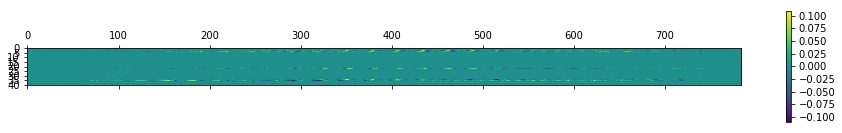

[[-1.47579063e-12 -2.73263840e-14 -7.77857799e-15 ...  1.31267470e-07
   1.11199799e-04 -1.91066329e-11]
 [-1.25595451e-10 -6.40739738e-19  5.36542581e-11 ...  5.22270102e-06
  -5.47570669e-13 -3.56353334e-14]
 [-2.06581334e-13 -9.97174782e-13 -5.31053157e-09 ...  1.25998959e-05
   1.82281799e-08 -4.29535191e-07]
 ...
 [-5.35813160e-06 -2.05761808e-05  3.50460461e-09 ... -1.21838166e-04
   1.62049822e-04  7.13716586e-12]
 [ 2.20680783e-11  1.23168302e-08  1.91613146e-17 ... -6.57352530e-06
  -2.42837905e-06 -4.32171532e-07]
 [-1.51040437e-24  5.04135134e-09  1.31809429e-06 ... -1.33684312e-04
   8.41820380e-04  5.01697173e-09]]


In [142]:
with tf.Session() as sess:
	sess.run(init)
	for epoch in range(n_epochs):
		for i in range(train_samples_size//batch_size):
			batch_index = np.random.choice(train_samples_size, batch_size, replace=False)
			X_batch = x_train_flat[batch_index, :]
			y_batch = y_train_soft[batch_index]
			sess.run([training_op,decaying_learning_rate],feed_dict={X:X_batch, y:y_batch})
		if epoch % 10 == 0:
			acc_train = sess.run(accuracy,feed_dict={X:X_batch, y:y_batch})
			acc_test = sess.run(accuracy,feed_dict={X:x_test_flat, y:y_test})
			print (epoch, 'train accuracy:', acc_train, 'test accuracy:', acc_test)
	
	#save_path = saver.save(sess, './my_f7_model_final.ckpt')
	acc_train = sess.run(accuracy,feed_dict={X:X_batch, y:y_batch})
	acc_test = sess.run(accuracy,feed_dict={X:x_test_flat, y:y_test})
	print (epoch, 'train accuracy:', acc_train, 'test accuracy:', acc_test)
	
	W_mat = W_rcat.eval()
	plt.matshow(W_mat)
	plt.colorbar()
	plt.show()
	print (W_mat)

- batchsize 100

**Visualizing learned parameters: SDT**

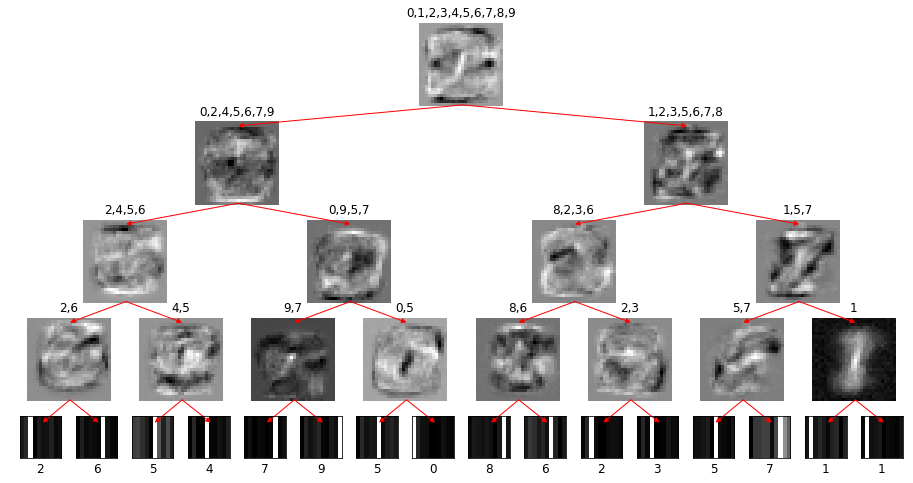

In [19]:
draw_tree(sess, tree, img_rows, img_cols, img_chans)

In [20]:
digit = 8

# get (reproducibly) pseudo-random example of chosen digit
np.random.seed(0)
sample_index = np.random.choice(np.where(np.argmax(y_test, axis=1)==digit)[0])
input_img = x_test[sample_index]

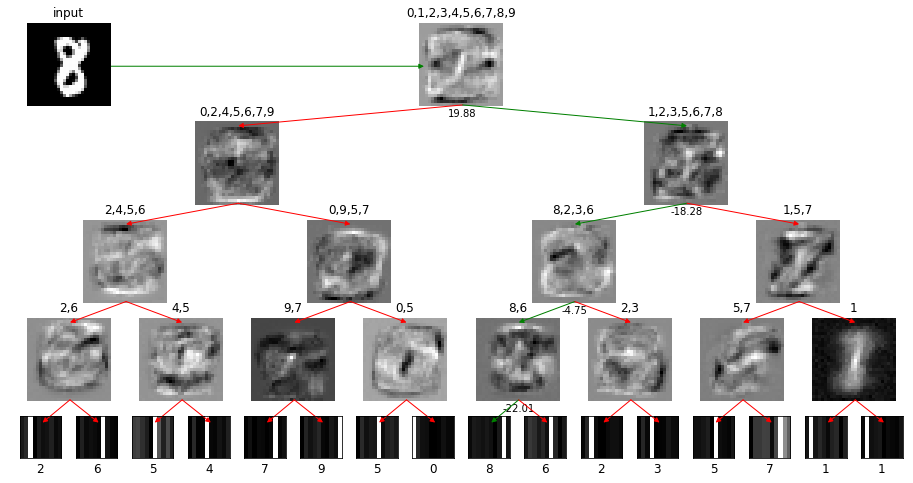

In [21]:
draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img)

In [22]:
#With 40 epochs, acc: 0.8882, val_acc: 0.8970
tree.model.fit(x=x_train_flat, y=y_train_soft, validation_data=(x_valid_flat, y_valid),
               batch_size=batch_size, epochs=3);

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 140s 3ms/sample - loss: 8.8152 - acc: 0.9173 - val_loss: 8.2559 - val_acc: 0.9166
Epoch 2/3
50000/50000 [==============================] - 140s 3ms/sample - loss: 8.8181 - acc: 0.9173 - val_loss: 8.2634 - val_acc: 0.9167
Epoch 3/3
50000/50000 [==============================] - 144s 3ms/sample - loss: 8.8134 - acc: 0.9176 - val_loss: 8.2372 - val_acc: 0.9169


Deeper tree

In [45]:
tree_depth = 5

In [46]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

tree.initialize_variables(sess, x_train_flat, batch_size)

Built tree has 32 leaves out of 63 nodes


In [47]:
tree.model.fit(x=x_train_flat, y=y_train_soft, validation_data=(x_valid_flat, y_valid),
               batch_size=batch_size, epochs=3);

# os.mkdir('assets/depth-{}'.format(tree_depth))
# tree.save_variables(sess, 'assets/depth-{}/tree-model'.format(tree_depth))

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 269s 5ms/sample - loss: 7.9366 - acc: 0.5585 - val_loss: 8.1102 - val_acc: 0.7777
Epoch 2/3
50000/50000 [==============================] - 220s 4ms/sample - loss: 8.1143 - acc: 0.8174 - val_loss: 8.1366 - val_acc: 0.8584
Epoch 3/3
50000/50000 [==============================] - 219s 4ms/sample - loss: 8.1236 - acc: 0.8547 - val_loss: 8.1323 - val_acc: 0.8760


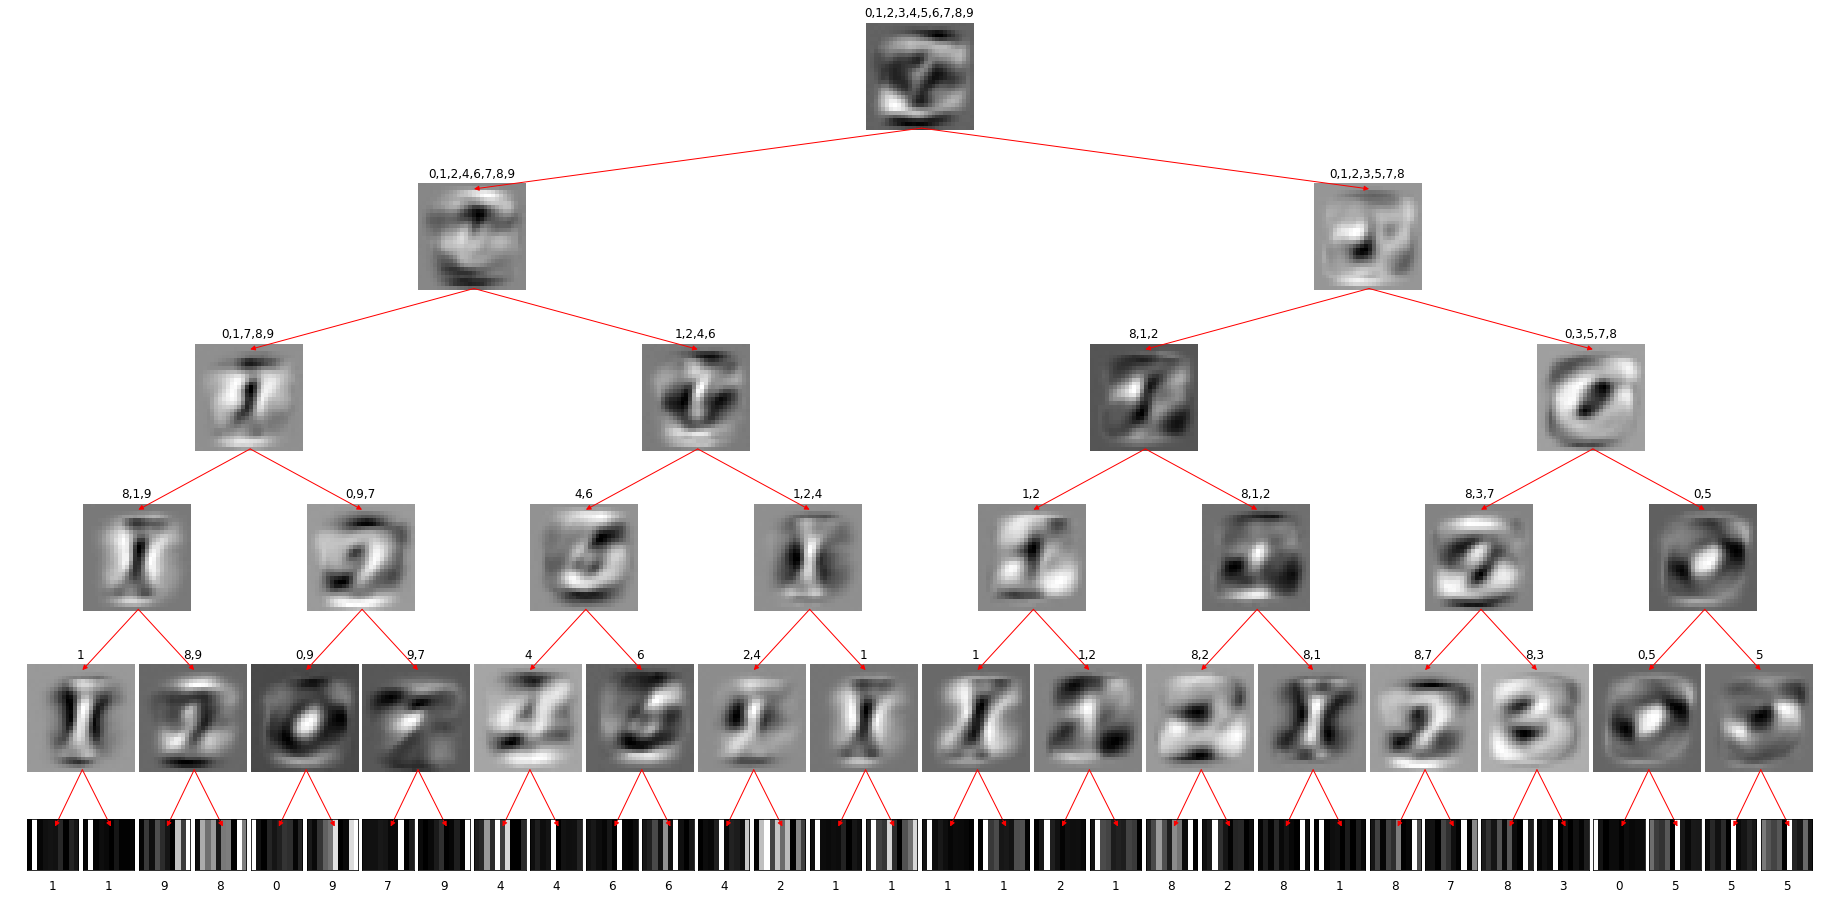

In [48]:
draw_tree(sess, tree, img_rows, img_cols, img_chans)

In [51]:
digit = 2

# get (reproducibly) pseudo-random example of chosen digit
np.random.seed(0)
sample_index = np.random.choice(np.where(np.argmax(y_test, axis=1)==digit)[0])
input_img = x_test[sample_index]

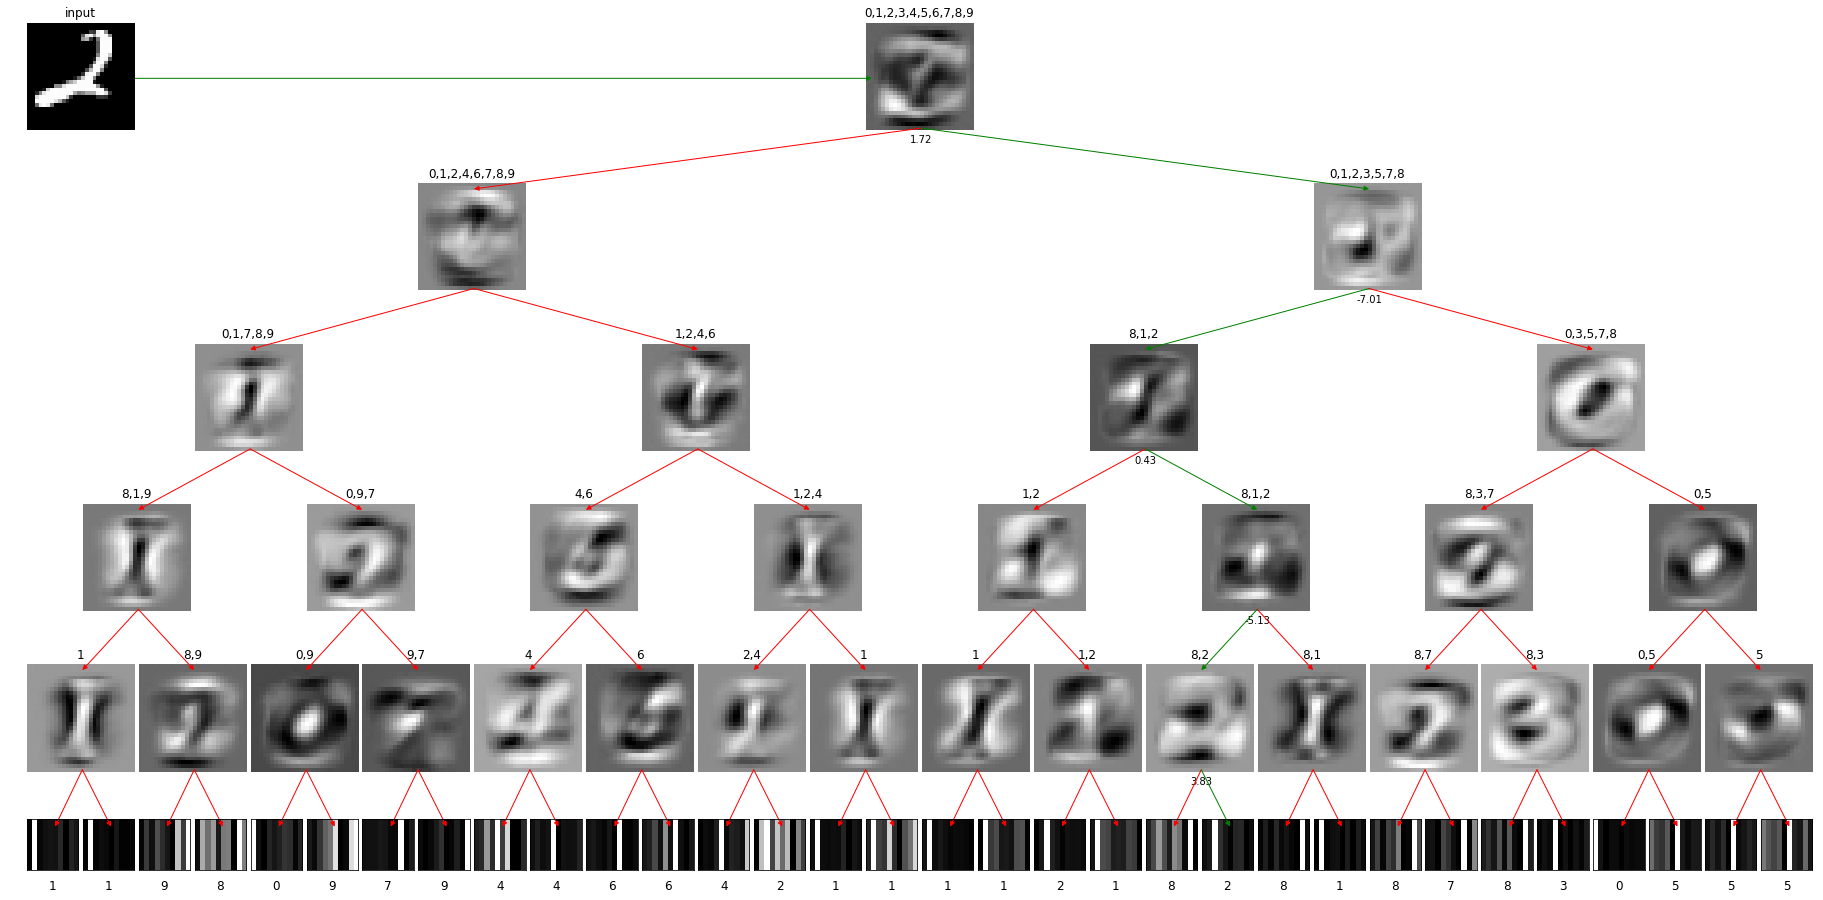

In [52]:
draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img)